# Denis_Stepanjuk_651840871
Denis_Stepanjuk_651840871

In [1]:
# The pickle module implements binary protocols for serializing 
# and de-serializing a Python object structure. 
# Сериализация — это процесс преобразования объекта в поток байтов 
# для сохранения или передачи в память, базу данных или файл.

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

In [2]:
import torch
import numpy as np
import PIL
print('PIL: ', PIL.__version__)
print('torch: ',torch.__version__)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

PIL:  10.0.1
torch:  2.1.1
CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi

In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224 # 299
# работаем на видеокарте
DEVICE = torch.device("cuda")
print(DEVICE)

cuda


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и с torch.Transformation.

ToTensor конвертирует PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:  𝑖𝑛𝑝𝑢𝑡=𝑖𝑛𝑝𝑢𝑡−𝜇standard deviation
 ,
константы - средние и дисперсии по каналам на основе ImageNet

Стоит также отметить, что мы переопределяем метод getitem для удобства работы с данной структурой данных. Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод _prepare_sample)

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            # записывает сериализованное представление объекта obj в открытый файловый объект.
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file) # Opens and identifies the given image file.
        image.load() # Allocates storage for the image and loads the pixel data. 
        return image # RETURNS: An image access object.

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
from sklearn.model_selection import train_test_split

#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('C:/Users/Deniss/Desktop/DLS DZ/simpsons_baseline/train')
TEST_DIR = Path('C:/Users/Deniss/Desktop/DLS DZ/simpsons_baseline/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

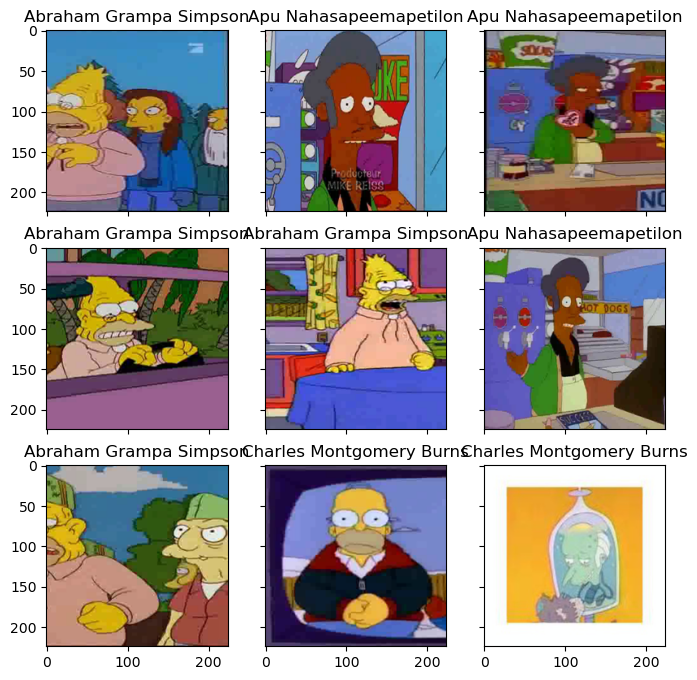

In [7]:
# Давайте посмотрим на наших героев внутри датасета.

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         scheduler.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [9]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [10]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(params=[
        {"params": model.fc.parameters()},
        {"params": model.avgpool.parameters()},
        {"params": model.layer4.parameters()}], lr = 1e-4)
        
        
        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, exp_lr_scheduler)
            print("loss", train_loss)
#             scheduler.step()

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [11]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
#             outputs = model(inputs).cuda()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [12]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [13]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [20]:
import torchvision.models as models
# resnet18 = models.resnet18()
# alexnet = models.alexnet()
# vgg16 = models.vgg16()
# squeezenet = models.squeezenet1_0()
# densenet = models.densenet161()
# inception = models.inception_v3()
# googlenet = models.googlenet()
# shufflenet = models.shufflenet_v2_x1_0()
# mobilenet = models.mobilenet_v2()
# resnext50_32x4d = models.resnext50_32x4d()
# wide_resnet50_2 = models.wide_resnet50_2()
# mnasnet = models.mnasnet1_0()
# model_alexnet = models.alexnet(pretrained=True)
model_resnext50 = models.resnext50_32x4d(pretrained=True)

In [19]:
# Можно загрузить обученную модель.
model_resnext50.load_state_dict(torch.load('models_resnext50_32x4d_0_96.pth'))

In [21]:
layers_to_unfreeze = 2
# for param in model_alexnet.features[:-layers_to_unfreeze].parameters():

for param in model_resnext50.parameters():
    param.requires_grad = False

In [22]:
in_features = 2048 # Входной слой полносвязной сети
simpsons_out = 42 # кол-во персонажей

model_resnext50.fc = torch.nn.Linear(in_features = in_features, out_features=simpsons_out, bias=True)

if torch.cuda.is_available(): # Подключаем GPU.
    print("torch.cuda.is_available(): ", torch.cuda.is_available())
    model_resnext50 = model_resnext50.cuda()
    


torch.cuda.is_available():  True


In [23]:
for param in model_resnext50.fc.parameters():
    param.requires_grad = True
for param in model_resnext50.avgpool.parameters():
    param.requires_grad = True
for param in model_resnext50.layer4.parameters():
    param.requires_grad = True    

In [25]:
history = train(train_dataset, val_dataset, model=model_resnext50, epochs=12, batch_size=64)

epoch:   0%|                                                                                                         | 0/4 [00:00<?, ?it/s]

loss 0.2296655586874409


epoch:  25%|████████████████████████                                                                        | 1/4 [04:09<12:28, 249.50s/it]


Epoch 001 train_loss: 0.2297     val_loss 0.1761 train_acc 0.9467 val_acc 0.9589
loss 0.11165460353112144


epoch:  50%|████████████████████████████████████████████████                                                | 2/4 [08:22<08:23, 251.52s/it]


Epoch 002 train_loss: 0.1117     val_loss 0.2161 train_acc 0.9703 val_acc 0.9501
loss 0.05742977890067372


epoch:  75%|████████████████████████████████████████████████████████████████████████                        | 3/4 [12:31<04:10, 250.54s/it]


Epoch 003 train_loss: 0.0574     val_loss 0.2535 train_acc 0.9850 val_acc 0.9429
loss 0.030399621137919105


epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [16:38<00:00, 249.63s/it]


Epoch 004 train_loss: 0.0304     val_loss 0.2226 train_acc 0.9920 val_acc 0.9589


In [26]:
loss, acc, val_loss, val_acc = zip(*history)

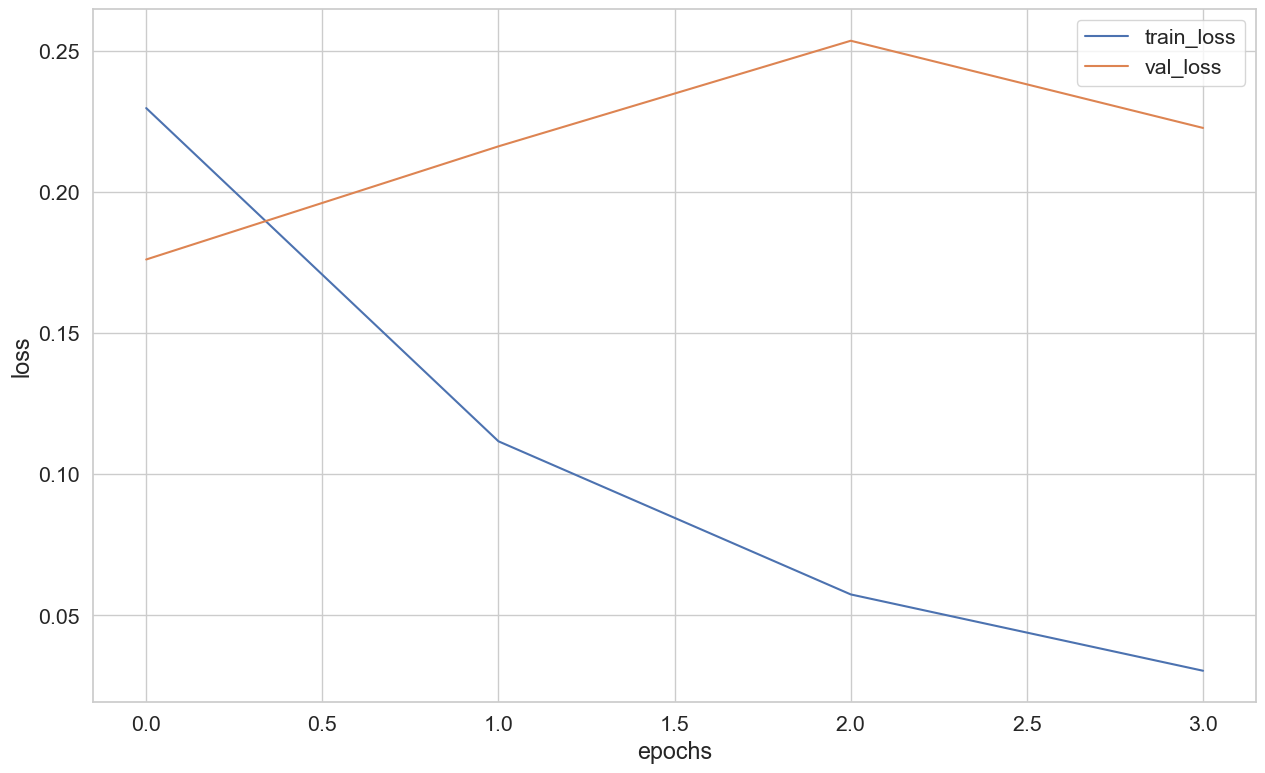

In [27]:
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [28]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnext50, ex_img.unsqueeze(0))

In [29]:
idxs = list(map(int, np.random.uniform(0,1000, 300)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnext50, imgs)

In [30]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [31]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [32]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.9666666666666667


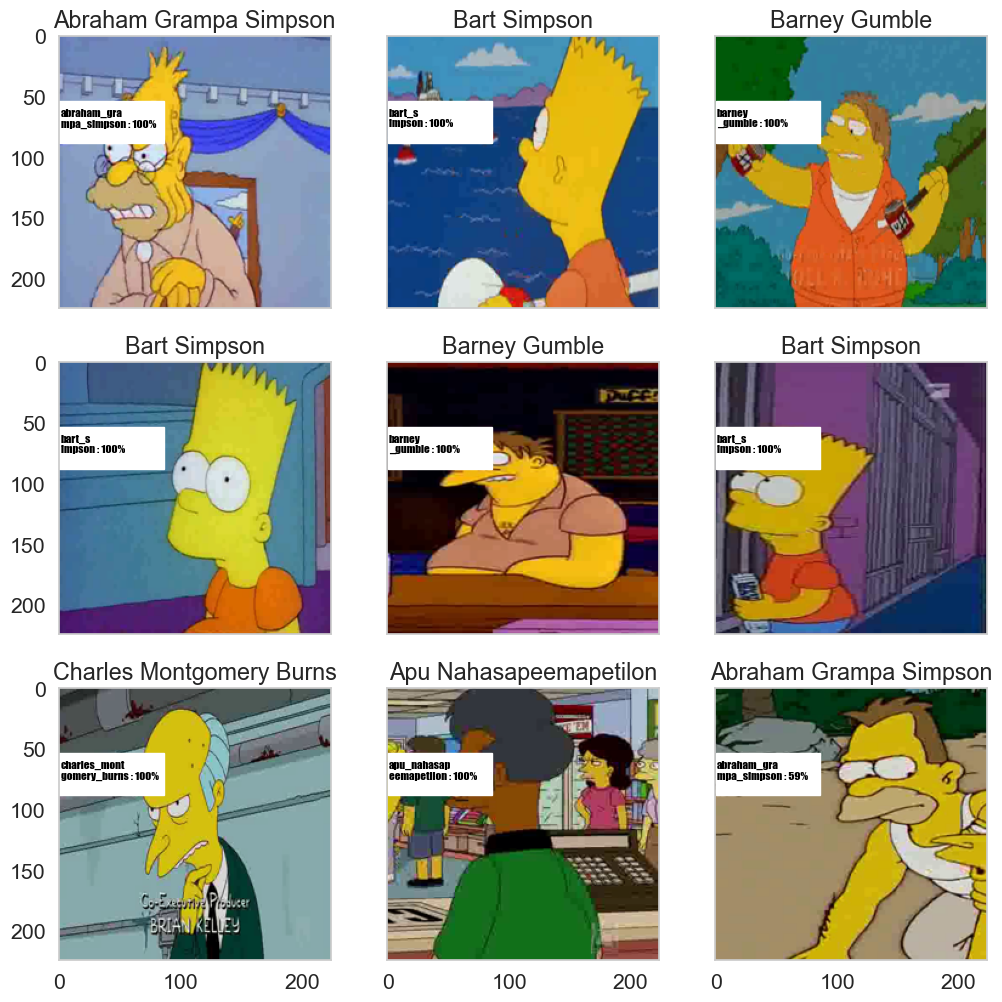

In [33]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnext50, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
# Сохранем модель
torch.save(model_resnext50.state_dict(),'models_LR_change_resnext50_32x4d_0_986.pth')

In [34]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnext50, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
my_submit.to_csv('C:/Users/Deniss/Desktop/DLS DZ/simpsons_baseline/models_LR_change_resnext50_32x4d_0_986.csv', index=False)

In [ ]:
# Denis_Stepanjuk_651840871